In [1]:
from db_connection import DB_Connection
import pandas as pd, numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.widgets import TextBox
import re, json
from wordcloud import WordCloud
import Tweet


db = DB_Connection()

database = db.query('''SELECT * FROM TWTTWEET WHERE TWEET_CREATED<'2021-01-01'
                    ORDER BY TWEET_CREATED DESC;''')
df = pd.DataFrame(database, columns=['id','userid','text','date',
                            'link','media1','media2','media3', 'media4'])
df = df.loc[:, ['id', 'text']]


processed = Tweet.clean_text(df, 'text')
classified = Tweet.classify_text(processed, 'clean')

# incidents = classified[['id','isIncident']].groupby('isIncident').size()
# accidents = classified[['id','isAccident']].groupby('isAccident').size()[1]
# dangers = classified[['id','isDanger']].groupby('isDanger').size()[1]
# obstacles = classified[['id','isObstacle']].groupby('isObstacle').size()[1]

Connection succesful.


In [2]:
joined = ' '.join([t for t in classified.clean])
joined = joined.split()
new_joined = pd.Series(joined)

In [3]:
len(new_joined.unique())

33733

In [ ]:
x = [0,1,2]
data = [accidents,obstacles,dangers]
plt.figure(figsize=(10,6))
g = sns.barplot(x=x, y=data)
plt.title('% de incidentes por categoría', fontsize=16)
plt.xticks(ticks=x,
        labels=['accidentes','obstáculos','peligros'],
        fontsize=13)
plt.ylim(top=65000)

for i, v in enumerate(data):
    g.text(i, v+1000, v, color='black', ha="center", fontsize=12)
    # plt.annotate(v, (i+3, 10), color='black', fontsize=12)
plt.show()

## Text classification

In [2]:
from sklearn.svm import LinearSVC
import pickle
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
classified.head(1)

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer1 = CountVectorizer(max_features=600, min_df=5, max_df=0.7)
X11 = vectorizer1.fit_transform(classified.clean).toarray()

In [4]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
X2 = tfidf.fit_transform(X11)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfi = TfidfVectorizer(sublinear_tf=True, max_features=600, min_df=5, max_df=0.7, encoding='utf-8', ngram_range=(1,2))
X3 = tfi.fit_transform(classified.clean).toarray()
# labels = classified.isIncident

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X2, classified.isIncident, test_size=0.2, random_state=0)

### Random Forest

In [8]:
start = time.time()
ranfor = RandomForestClassifier()
ranfor.fit(X_train, y_train)
end = time.time()
print('Duration:', str(end-start))

y_pred = ranfor.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

Duration: 216.16058540344238
[[18571    53]
 [  540 15926]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18624
           1       1.00      0.97      0.98     16466

    accuracy                           0.98     35090
   macro avg       0.98      0.98      0.98     35090
weighted avg       0.98      0.98      0.98     35090

0.9831005984611


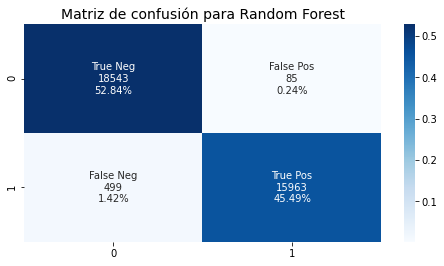

In [14]:
rf_con = confusion_matrix(y_test,y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                rf_con.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     rf_con.flatten()/np.sum(rf_con)]
labels = ['%s\n%s\n%s' % (v1, v2, v3) for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(8,4))
sns.heatmap(rf_con/np.sum(rf_con), annot=labels, fmt='', cmap='Blues')
plt.title('Matriz de confusión para Random Forest', fontsize=14)
plt.show()

In [ ]:
with open('ranfor_classifier', 'wb') as picklefile:
    pickle.dump(ranfor, picklefile)

In [ ]:
# load model
with open('ranfor_classifier', 'rb') as training_model:
    ranfor = pickle.load(training_model)

In [ ]:
resume = []
for i in [16,32,64]:#,128,256,512,1024,2048,4096,8192]:
    print('\nPrediction with:', str(i))
    start = time.time()
    ranfor = RandomForestClassifier(n_estimators=i, random_state=0)
    ranfor.fit(X_train, y_train)
    end = time.time()
    y_pred = ranfor.predict(X_test)
    print(str(end-start), accuracy_score(y_test, y_pred))
    resume.append([i, end-start, accuracy_score(y_test, y_pred),
        confusion_matrix(y_test,y_pred), classification_report(y_test,y_pred)])

In [ ]:
for i in [128,256,512,1024,2048,4096,8192]:
    print('\nPrediction with:', str(i))
    start = time.time()
    ranfor = RandomForestClassifier(n_estimators=i, random_state=0)
    ranfor.fit(X_train, y_train)
    end = time.time()
    y_pred = ranfor.predict(X_test)
    print(str(end-start), accuracy_score(y_test, y_pred))
    resume.append([i, end-start, accuracy_score(y_test, y_pred),
        confusion_matrix(y_test,y_pred), classification_report(y_test,y_pred)])

In [ ]:
xs = [i[0] for i in resume]
ys = [i[1] for i in resume]
zs = [i[2] for i in resume]

In [ ]:
plt.figure(figsize=(11,4))
plt.subplot(1, 2, 1)
sns.pointplot(x=xs, y=ys)
# sns.lineplot(x=range(len(xs)), y=ys, markers=True, style='event')
plt.title('Duración de entrenamiento')
plt.xticks(range(len(xs)), xs)
plt.subplot(1, 2, 2)
sns.pointplot(x=xs, y=zs)
plt.title('Precisión obtenida')
plt.xticks(range(len(xs)), xs)
plt.show()

### Boosting Model

In [9]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn import metrics
import xgboost as xgb
import time

In [10]:
from xgboost import XGBClassifier

start = time.time()
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
end = time.time()
print('Duration:', str(end-start))

y_xgb = xgb.predict(X_test)

print(confusion_matrix(y_test,y_xgb))
print(classification_report(y_test,y_xgb))
print(accuracy_score(y_test, y_xgb))

[19:07:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Duration: 30.898895025253296
[[18604    20]
 [  648 15818]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18624
           1       1.00      0.96      0.98     16466

    accuracy                           0.98     35090
   macro avg       0.98      0.98      0.98     35090
weighted avg       0.98      0.98      0.98     35090

0.9809632373895697


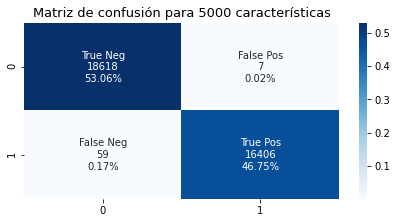

In [8]:
xgb_con = confusion_matrix(y_test,y_xgb2)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                xgb_con.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     xgb_con.flatten()/np.sum(xgb_con)]
labels = ['%s\n%s\n%s' % (v1, v2, v3) for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(6,3.2))
sns.heatmap(xgb_con/np.sum(xgb_con), annot=labels, fmt='', cmap='Blues')
plt.title('Matriz de confusión para 5000 características', fontsize=13)
plt.tight_layout()
plt.show()

In [ ]:
xgresume = []

for i in [64,128,256,512,1024,2048,4096]:
    print('\nestimators:', str(i))
    start = time.time()
    xgb = XGBClassifier(n_estimators=i, learning_rate=0.3, eval_metric='error') # learning_rate
    xgb.fit(X_train, y_train)
    end = time.time()
    y_xgb = xgb.predict(X_test)
    print(str(end-start), accuracy_score(y_test, y_xgb))
    xgresume.append([i, end-start, accuracy_score(y_test, y_xgb),
    confusion_matrix(y_test,y_xgb), classification_report(y_test,y_xgb)])

In [ ]:
xs = [i[0] for i in xgresume]
ys = [i[2] for i in xgresume]
zs = [i[3] for i in xgresume]

plt.figure(figsize=(11,4))
plt.title('XGBoost')
plt.subplot(1, 2, 1)
sns.pointplot(x=xs, y=ys)
# sns.lineplot(x=range(len(xs)), y=ys, markers=True, style='event')
plt.title('Duración de entrenamiento')
plt.xticks(range(len(xs)), xs)
plt.subplot(1, 2, 2)
sns.pointplot(x=xs, y=zs)
plt.title('Precisión obtenida')
plt.xticks(range(len(xs)), xs)
plt.show()

### SVM

In [11]:
start = time.time()
svc = LinearSVC()
svc.fit(X_train, y_train)
end = time.time()
print('Duration:', str(end-start))

y_svc = svc.predict(X_test)

print(confusion_matrix(y_test,y_svc))
print(classification_report(y_test,y_svc))
print(accuracy_score(y_test, y_svc))

Duration: 1.444676399230957
[[18574    50]
 [  679 15787]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     18624
           1       1.00      0.96      0.98     16466

    accuracy                           0.98     35090
   macro avg       0.98      0.98      0.98     35090
weighted avg       0.98      0.98      0.98     35090

0.979224850384725


In [ ]:
with open('svc_classifier', 'wb') as picklefile:
    pickle.dump(svc, picklefile)

In [ ]:
# load model
with open('ranfor_classifier', 'rb') as training_model:
    ranfor = pickle.load(training_model)

### Naive-Bayes

In [12]:
from sklearn.naive_bayes import MultinomialNB

start = time.time()
nb = MultinomialNB()
nb.fit(X_train, y_train)
end = time.time()
print('Duration:', str(end-start))

y_nb = nb.predict(X_test)

print(confusion_matrix(y_test,y_nb))
print(classification_report(y_test,y_nb))
print(accuracy_score(y_test, y_nb))

Duration: 0.0718083381652832
[[16754  1870]
 [  628 15838]]
              precision    recall  f1-score   support

           0       0.96      0.90      0.93     18624
           1       0.89      0.96      0.93     16466

    accuracy                           0.93     35090
   macro avg       0.93      0.93      0.93     35090
weighted avg       0.93      0.93      0.93     35090

0.9288116272442292


### Gaussian Naive-Bayes

In [13]:
from sklearn.naive_bayes import GaussianNB

start = time.time()
gnb = GaussianNB()
gnb.fit(X_train, y_train)
end = time.time()
print('Duration:', str(end-start))

y_gnb = gnb.predict(X_test)

print(confusion_matrix(y_test,y_gnb))
print(classification_report(y_test,y_gnb))
print(accuracy_score(y_test, y_gnb))

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

### Boosting RF Model

In [ ]:
from xgboost import XGBRFClassifier

start = time.time()
xrfgb = XGBRFClassifier()
xrfgb.fit(X_train, y_train)
end = time.time()
print('Duration:', str(end-start))

y_xrfgb = xrfgb.predict(X_test)

print(confusion_matrix(y_test,y_xrfgb))
print(classification_report(y_test,y_xrfgb))
print(accuracy_score(y_test, y_xrfgb))